In [1]:
from diffrax import diffeqsolve, ODETerm, Dopri5
import jax.numpy as jnp
import jax
from jax import jit

In [2]:
@jit
def f(t, y, args):
    # jax.debug.print("y: {}", y)
    return -y

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
solution

Solution(
  t0=f32[],
  t1=f32[],
  ts=f32[1],
  ys=f32[1,2],
  interpolation=None,
  stats={
    'max_steps':
    i32[],
    'num_accepted_steps':
    i32[],
    'num_rejected_steps':
    i32[],
    'num_steps':
    i32[]
  },
  result=i32[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

## Qutip example

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qu

# Define Pauli matrices
sigma_x = qu.sigmax()
sigma_y = qu.sigmay()
sigma_z = qu.sigmaz()

# Define Hamiltonian (H = omega * sigma_x / 2)
omega = 1.0
H = omega * sigma_x / 2

# Initial state (|0>)
psi0 = qu.basis(2, 0)

# Initial propagator
U0 = qu.identity(2)

# Time list
times = np.linspace(0, 10, 100)




In [5]:
# Solve Schrodinger equation
result = qu.mesolve(H, psi0, times, [], [sigma_x, sigma_y, sigma_z])

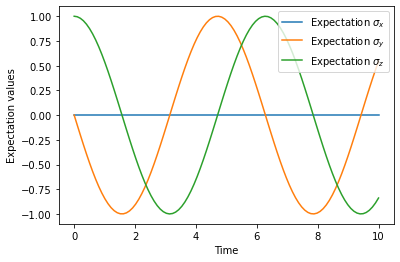

In [6]:
# Plot the results
plt.figure()
plt.plot(times, result.expect[0], label="Expectation $\sigma_x$")
plt.plot(times, result.expect[1], label="Expectation $\sigma_y$")
plt.plot(times, result.expect[2], label="Expectation $\sigma_z$")
plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.legend()
plt.show()

In [7]:
# Solve Schrodinger equation
result = qu.mesolve(H, psi0, times)
# Take the final state
final_state = result.states[-1]

In [8]:
final_state.full()

array([[0.28365322+0.j        ],
       [0.        +0.95892693j]])

In [9]:
# Take the final propagator
U_T = qu.propagator(H, times)[-1]

In [10]:
U_T.full()

array([[0.28366625+0.j        , 0.        +0.95892307j],
       [0.        +0.95892307j, 0.28366625+0.j        ]])

## Diffrax propagator solver

In [11]:
# Convert all the qutip object in jax objects
H_jax = jnp.array(H.full())
psi0_jax = jnp.array(psi0.full())
times_jax = jnp.array(times)
U0_jax = jnp.array(U0.full())

# Consider the isomorphism to map the Schroedinger equation into a real valued system
H_iso_jax = jnp.kron(jnp.eye(2), jnp.imag(H_jax)) + jnp.kron(jnp.array([[0, 1], [-1, 0]]), jnp.real(H_jax))

# Define the initial state to be consistent with the isomorphism, i.e. 
psi_0_iso_jax = jnp.kron(jnp.array([1, 0]), jnp.real(psi0_jax)) + jnp.kron(jnp.array([0, 1]), jnp.imag(psi0_jax))
U0_iso_jax = jnp.kron(jnp.array([1, 0]), jnp.real(U0_jax)) + jnp.kron(jnp.array([0, 1]), jnp.imag(U0_jax))


In [12]:
H_iso_jax.shape

(4, 4)

In [13]:
psi_0_iso_jax.shape

(2, 2)

In [14]:
# Reshape psi_0_iso_jax
psi_0_iso_reshaped_jax = psi_0_iso_jax.reshape((4, ))

In [15]:
H_iso_jax @ psi_0_iso_reshaped_jax

Array([ 0. ,  0. ,  0. , -0.5], dtype=float32)

In [16]:
from functools import partial
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

In [17]:
H_jax

Array([[0. +0.j, 0.5+0.j],
       [0.5+0.j, 0. +0.j]], dtype=complex64)

In [18]:
H_iso_jax

Array([[ 0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0.5,  0. ],
       [ 0. , -0.5,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ]], dtype=float32)

In [19]:
# Define the function to compute the derivative of the state

def f_qu(t, psi, args):
    # jax.debug.print("psi: {}", psi)
    H, = args
    return jnp.matmul(H, psi)

term = ODETerm(f_qu)
solver = Tsit5()


In [20]:
# Compute the solution using the jax solver
solution = diffeqsolve(term, solver, t0=0.0, t1=10.0, dt0=0.005, y0=psi_0_iso_reshaped_jax, args = (H_iso_jax,))


In [21]:
solution.ys

Array([[0.28366348, 0.        , 0.        , 0.9589276 ]],      dtype=float32, weak_type=True)

In [22]:
# Define the function to compute the derivative of the state

def f_qu(t, U, args):
    # jax.debug.print("U: {}", U)
    H, = args
    return jnp.matmul(H, U)

term = ODETerm(f_qu)
solver = Tsit5()

In [23]:
U0_iso_jax_reshaped = U0_iso_jax.T

In [24]:
U0_iso_jax_reshaped

Array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [25]:
jnp.matmul(H_iso_jax, U0_iso_jax_reshaped)

Array([[ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. , -0.5],
       [-0.5,  0. ]], dtype=float32)

In [26]:
# Compute the solution using the jax solver
solution = diffeqsolve(term, solver, t0=0.0, t1=10.0, dt0=0.005, y0=U0_iso_jax_reshaped, args = (H_iso_jax,))

In [27]:
solution.ys

Array([[[0.28366277, 0.        ],
        [0.        , 0.28366277],
        [0.        , 0.95892495],
        [0.95892495, 0.        ]]], dtype=float32, weak_type=True)